# Consumer Complaints Dataset

Task 6. Data Science example.
Perform a Text Classification on consumer complaint dataset
(https://catalog.data.gov/dataset/consumer-complaint-database) into following categories.
0 Credit reporting, repair, or
other
1 Debt collection
2 Consumer Loan
3 Mortgage
Steps to be followed -
1. Explanatory Data Analysis and Feature Engineering
2. Text Pre-Processing
3. Selection of Multi Classification model
4. Comparison of model performance
5. Model Evaluation
6. Prediction

<a id='imp'></a>
## Importing packages and loading data

In [2]:
# Input data files are available in the "../input/" directory.
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.exceptions import ConvergenceWarning
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.tools as tls
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [3]:
# loading data
df = pd.read_csv('/kaggle/input/19mia1073-complaints/complaints.csv')
df.shape

(4078867, 18)

We have 40,78,867 rows and 18 features (columns).

In [4]:
df.head(2).T 

,0,1
Date received,2023-08-25,2023-08-25
Product,Credit reporting or other personal consumer re...,Credit reporting or other personal consumer re...
Sub-product,Credit reporting,Credit reporting
Issue,Problem with a company's investigation into an...,Incorrect information on your report
Sub-issue,Their investigation did not fix an error on yo...,Information belongs to someone else
Consumer complaint narrative,NaN,NaN
Company public response,NaN,NaN
Company,"EQUIFAX, INC.","EQUIFAX, INC."
State,PA,GA
ZIP code,15146,30152


# Part 1: DATA EXPLORATION

In [5]:
df['Date received'] = pd.to_datetime(df['Date received'])
df['year_received'], df['month_received'] = df['Date received'].dt.year, df['Date received'].dt.month
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,year_received,month_received
0,2023-08-25,Credit reporting or other personal consumer re...,Credit reporting,Problem with a company's investigation into an...,Their investigation did not fix an error on yo...,NaN,NaN,"EQUIFAX, INC.",PA,15146,NaN,NaN,Web,2023-08-26,Closed with explanation,Yes,NaN,7560850,2023,8
1,2023-08-25,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"EQUIFAX, INC.",GA,30152,NaN,NaN,Web,2023-08-25,Closed with explanation,Yes,NaN,7560851,2023,8
2,2023-08-25,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,NaN,NaN,"EQUIFAX, INC.",FL,32137,NaN,Other,Web,2023-08-25,Closed with explanation,Yes,NaN,7560852,2023,8
3,2023-08-25,Credit reporting or other personal consumer re...,Credit reporting,Problem with a company's investigation into an...,Their investigation did not fix an error on yo...,NaN,NaN,"EQUIFAX, INC.",PA,15146,NaN,NaN,Web,2023-08-25,Closed with explanation,Yes,NaN,7560853,2023,8
4,2023-08-25,Credit reporting or other personal consumer re...,Credit reporting,Problem with a company's investigation into an...,Their investigation did not fix an error on yo...,NaN,NaN,"EQUIFAX, INC.",NV,89135,NaN,NaN,Web,2023-08-25,Closed with explanation,Yes,NaN,7560854,2023,8


# Part 2 : TEXT BASED MODELLING

The dataset contains features that are not necessary to solve our multi-classification problem. For this text classification problem, we are going to build another dataframe that contains ‘Product’ and ‘Consumer complaint narrative’ (renamed as 'Consumer_complaint').

In [6]:
# Create a new dataframe with two columns
df1 = df[['Product', 'Consumer complaint narrative']].copy()

# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['Consumer complaint narrative'])]

# Renaming second column for a simpler name
df1.columns = ['Product', 'Consumer_complaint'] 

df1.shape

(1477894, 2)

In [7]:
# Percentage of complaints with text
total = df1['Consumer_complaint'].notnull().sum()
round((total/len(df)*100),1)

36.2

In [8]:
pd.DataFrame(df.Product.unique()).values

array([['Credit reporting or other personal consumer reports'],
       ['Credit reporting, credit repair services, or other personal consumer reports'],
       ['Checking or savings account'],
       ['Mortgage'],
       ['Debt collection'],
       ['Credit card'],
       ['Student loan'],
       ['Credit card or prepaid card'],
       ['Vehicle loan or lease'],
       ['Payday loan, title loan, personal loan, or advance loan'],
       ['Money transfer, virtual currency, or money service'],
       ['Prepaid card'],
       ['Debt or credit management'],
       ['Payday loan, title loan, or personal loan'],
       ['Credit reporting'],
       ['Bank account or service'],
       ['Consumer Loan'],
       ['Payday loan'],
       ['Money transfers'],
       ['Other financial service'],
       ['Virtual currency']], dtype=object)

In [9]:
# Because the computation is time consuming (in terms of CPU), the data was sampled
df2 = df1.sample(10000, random_state=1).copy()

In [11]:
# Define a mapping dictionary to categorize products
product_mapping = {
    'Credit reporting, credit repair services, or other personal consumer reports': 'Credit reporting, repair, or other',
    'Credit reporting': 'Credit reporting, repair, or other',
    'Checking or savings account': 'Consumer Loan',
    'Mortgage': 'Mortgage',
    'Debt collection': 'Debt collection',
    'Credit card': 'Credit reporting, repair, or other',
    'Student loan': 'Consumer Loan',
    'Credit card or prepaid card': 'Credit reporting, repair, or other',
    'Vehicle loan or lease': 'Consumer Loan',
    'Payday loan, title loan, personal loan, or advance loan': 'Debt collection',
    'Money transfer, virtual currency, or money service': 'Credit reporting, repair, or other',
    'Prepaid card': 'Credit reporting, repair, or other',
    'Debt or credit management': 'Debt collection',
    'Payday loan, title loan, or personal loan': 'Debt collection',
    'Bank account or service': 'Consumer Loan',
    'Consumer Loan': 'Consumer Loan',
    'Payday loan': 'Debt collection',
    'Money transfers': 'Credit reporting, repair, or other',
    'Other financial service': 'Credit reporting, repair, or other',
    'Virtual currency': 'Credit reporting, repair, or other'
}

# First, replace some values using the product_mapping dictionary
df2['Product'].replace(product_mapping, inplace=True)

# Define a second mapping dictionary for further replacements
product_mapping_2 = {
    'Other financial service': 'Credit reporting, repair, or other',
    'Virtual currency': 'Credit reporting, repair, or other'
}

# Next, replace additional values using the product_mapping_2 dictionary
df2['Product'].replace(product_mapping_2, inplace=True)

In [12]:
pd.DataFrame(df2.Product.unique())

,0
0,Mortgage
1,"Credit reporting, repair, or other"
2,Debt collection
3,Consumer Loan
4,Credit reporting or other personal consumer re...


The number of classes were reduced from 12 to 10. <br><br>Now we need to represent each class as a number, so as our predictive model can better understand the different categories.

In [13]:
# Create a new column 'category_id' with encoded categories 
df2['category_id'] = df2['Product'].factorize()[0]
category_id_df = df2[['Product', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

# New dataframe
df2.head()

,Product,Consumer_complaint,category_id
1511706,Mortgage,Paying extremely high PMI for 11 years on my m...,0
1191532,"Credit reporting, repair, or other",I am requesting again in regards to the inaccu...,1
1191375,Debt collection,Offices of XXXX and XXXX XXXX XXXX XXXX ( no s...,2
2535195,"Credit reporting, repair, or other",I submitted a letter to the 3 Credit Bureaus t...,1
2583742,Consumer Loan,This is Cashap stealing {$230.00} from my acco...,3


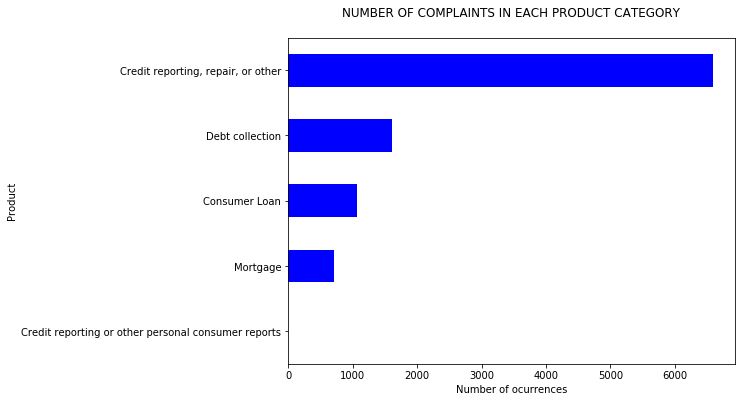

In [14]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
df2.groupby('Product').Consumer_complaint.count().sort_values().plot.barh(
    ylim=0, color='Blue', title= 'NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

<a id='pre'></a>
## Text Preprocessing :

The text needs to be transformed to vectors so as the algorithms will be able make predictions. In this case it will be used the Term Frequency – Inverse Document Frequency (TFIDF) weight to evaluate __how important a word is to a document in a collection of documents__.

After removing __punctuation__ and __lower casing__ the words, importance of a word is determined in terms of its frequency.

### “Term Frequency – Inverse Document Frequency 

__TF-IDF__ is the product of the __TF__ and __IDF__ scores of the term.<br><br> $$\text{TF-IDF}=\frac{\text{TF}}{\text{IDF}}$$<br>

__Term Frequency :__ This summarizes how often a given word appears within a document.

$$\text{TF} = \frac{\text{Number of times the term appears in the doc}}{\text{Total number of words in the doc}}$$<br><br>
__Inverse Document Frequency:__ This downscales words that appear a lot across documents. A term has a high IDF score if it appears in a few documents. Conversely, if the term is very common among documents (i.e., “the”, “a”, “is”), the term would have a low IDF score.<br>

$$\text{IDF} = \ln\left(\frac{\text{Number of docs}}{\text{Number docs the term appears in}} \right)$$<br>

TF-IDF are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across documents. The higher the TFIDF score, the rarer the term is. For instance, in a Mortgage complaint the word _mortgage_ would be mentioned fairly often. However, if we look at other complaints, _mortgage_ probably would not show up in many of them. We can infer that _mortgage_ is most probably an important word in Mortgage complaints as compared to the other products. Therefore, _mortgage_ would have a high TF-IDF score for Mortgage complaints.

TfidfVectorizer class can be initialized with the following parameters:
* __min_df__: remove the words from the vocabulary which have occurred in less than ‘min_df’ number of files.
* __max_df__: remove the words from the vocabulary which have occurred in more than _‘max_df’ * total number of files in corpus_.
* __sublinear_tf__: set to True to scale the term frequency in logarithmic scale.
* __stop_words__: remove the predefined stop words in 'english'.
* __use_idf__: weight factor must use inverse document frequency.
* __ngram_range__: (1, 2) to indicate that unigrams and bigrams will be considered.

In [15]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df2.Consumer_complaint).toarray()

labels = df2.category_id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 10000 complaints is represented by 26018 features (TF-IDF score of unigrams and bigrams)


In [16]:
# Finding the three most correlated terms with each of the product categories
N = 3
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(Product))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> Consumer Loan:
  * Most Correlated Unigrams are: overdraft, navient, bank
  * Most Correlated Bigrams are: savings account, overdraft fees, checking account

==> Credit reporting or other personal consumer reports:
  * Most Correlated Unigrams are: 720, urgency, avenues
  * Most Correlated Bigrams are: theft debt, report currently, 00 victim

==> Credit reporting, repair, or other:
  * Most Correlated Unigrams are: mortgage, loan, debt
  * Most Correlated Bigrams are: reporting agency, 15 1681, 1681 section

==> Debt collection:
  * Most Correlated Unigrams are: collect, collection, debt
  * Most Correlated Bigrams are: trying collect, collection agency, collect debt

==> Mortgage:
  * Most Correlated Unigrams are: escrow, modification, mortgage
  * Most Correlated Bigrams are: mortgage company, loan modification, mortgage payment


<a id='ml'></a>
## Multi-Classification models : 

The classification models evaluated are: 
* Random Forest
* Linear Support Vector Machine
* Multinomial Naive Bayes 
* Logistic Regression.

<a id='sp'></a>
### Spliting the data into train and test sets
The original data was divided into features (X) and target (y), which were then splitted into train (75%) and test (25%) sets. Thus, the algorithms would be trained on one set of data and tested out on a completely different set of data (not seen before by the algorithm).

In [17]:
X = df2['Consumer_complaint'] # Collection of documents
y = df2['Product'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

<a id='m'></a>
## Models:

In [18]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

<a id='sum'></a>
## Comparison of model performance

The best mean acuracy was obtained with LinearSVC.

In [19]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.853500,0.004623
LogisticRegression,0.832402,0.005003
MultinomialNB,0.734100,0.005746
RandomForestClassifier,0.659800,0.000355


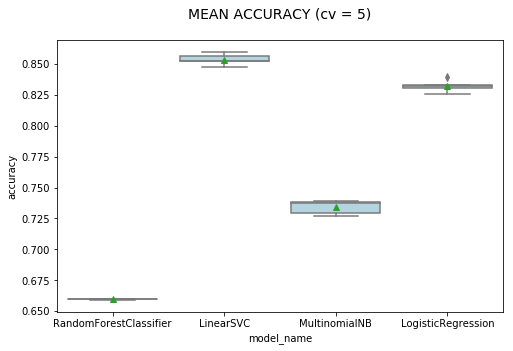

In [20]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

<a id='ev'></a>
## Model Evaluation :

In [21]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df2.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [22]:
df2.head()

,Product,Consumer_complaint,category_id
1511706,Mortgage,Paying extremely high PMI for 11 years on my m...,0
1191532,"Credit reporting, repair, or other",I am requesting again in regards to the inaccu...,1
1191375,Debt collection,Offices of XXXX and XXXX XXXX XXXX XXXX ( no s...,2
2535195,"Credit reporting, repair, or other",I submitted a letter to the 3 Credit Bureaus t...,1
2583742,Consumer Loan,This is Cashap stealing {$230.00} from my acco...,3


In [23]:
df2['category_id'].unique()

array([0, 1, 2, 3, 4])

<a id='m'></a>
## Precision, Recall, F1-score :

In [26]:
class_labels = ['Credit reporting, repair, or other', 'Debt collection', 'Consumer Loan', 'Mortgage']

print('\t\t\t\tCLASSIFICATION METRICS\n')
print(metrics.classification_report(y_test, y_pred, target_names=class_labels))

				CLASSIFICATION METRICS

                                    precision    recall  f1-score   support

Credit reporting, repair, or other       0.85      0.89      0.87       157
                   Debt collection       0.87      0.94      0.90      1633
                     Consumer Loan       0.81      0.64      0.72       436
                          Mortgage       0.71      0.63      0.67       274

                         micro avg       0.85      0.85      0.85      2500
                         macro avg       0.81      0.77      0.79      2500
                      weighted avg       0.84      0.85      0.84      2500



<a id='cm'></a>
## Confusion Matrix : 

A Confusion Matrix is a table which rows represent the actual class and columns represents the predicted class.<br><br>
If we had a perfect model that always classifies correctly a new complaint, then the confusion matrix would have values in the diagonal only (where predicted label = actual label).

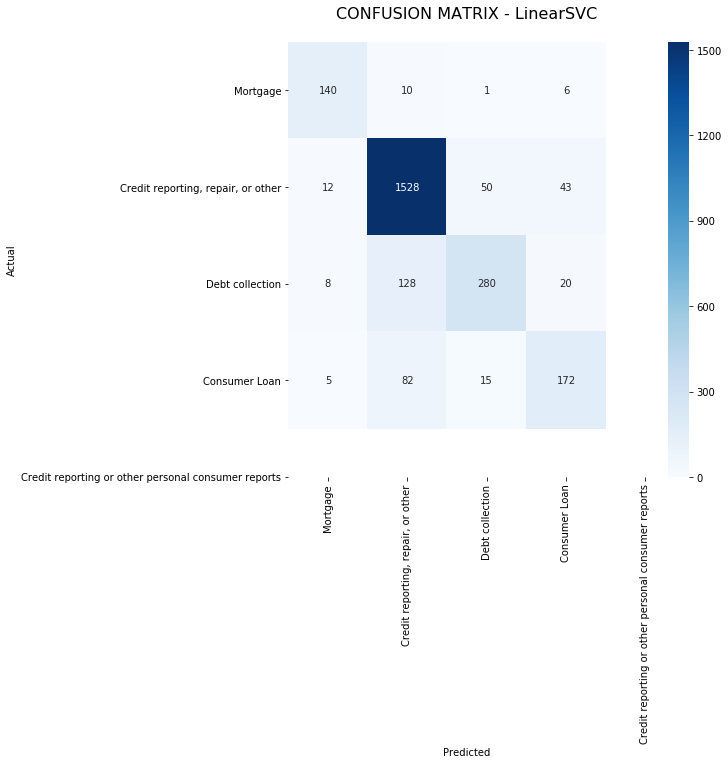

In [27]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Product.values, 
            yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

In general, the confusion matrix looks good (clear diagonal that represents correct classifications). Nevertheless, there are cases were the complaint was classified in a wrong class.

## Misclassified complaints :
Let’s have a look at the cases that were wrongly classified.

In [30]:
for actual in category_id_df.category_id.unique():
    for predicted in category_id_df.category_id.unique():
        if predicted != actual and actual < conf_mat.shape[0] and predicted < conf_mat.shape[1] and conf_mat[actual, predicted] >= 20:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], 
                                                               id_to_category[predicted], 
                                                               conf_mat[actual, predicted]))
            display(df2.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 
                                                                'Consumer_complaint']])
            print('')


'Credit reporting, repair, or other' predicted as 'Debt collection' : 50 examples.


,Product,Consumer_complaint
635034,"Credit reporting, repair, or other",XXXX XXXX is trying to collect on behalf of XX...
2629447,"Credit reporting, repair, or other",TO WHOM THIS MAY CONCERN I PREVIOUSLY DISPUTED...
1499130,"Credit reporting, repair, or other",I made a payment for my XX/XX/2021 bill which ...
518100,"Credit reporting, repair, or other",I am requesting for VALIDATION made pursuant t...
1651718,"Credit reporting, repair, or other",NAR INC Never once contacted me. I have no ide...
1144727,"Credit reporting, repair, or other",Mountain Run Solutions LLC has stole my inform...
76693,"Credit reporting, repair, or other",I disputed a transaction with Capital One. I r...
2511699,"Credit reporting, repair, or other",nca has never sent me a bill or verification f...
67144,"Credit reporting, repair, or other",INACCURATE account being reported negatively a...
1724121,"Credit reporting, repair, or other",I disputed XXXX ( XXXX XXXX ) in the amount of...



'Credit reporting, repair, or other' predicted as 'Consumer Loan' : 43 examples.


,Product,Consumer_complaint
1284745,"Credit reporting, repair, or other",I received a letter from XXXX XXXX aroun...
417263,"Credit reporting, repair, or other","On XX/XX/19, I called TD customer service to f..."
1443018,"Credit reporting, repair, or other",For the past couple of months I have been on X...
2894962,"Credit reporting, repair, or other",I downloaded the XXXX XXXX XXXX. ( XXXX XXXX X...
489048,"Credit reporting, repair, or other",On XX/XX/2021 Pay Pal made an unauthorized wit...
256955,"Credit reporting, repair, or other",I had a life insurance check from XXXX XXXX fo...
3832724,"Credit reporting, repair, or other",XXXX XXXX XXXX I was a victim of a scam invol...
1735871,"Credit reporting, repair, or other",I opened a secured personal loan with XXXX XXX...
3927448,"Credit reporting, repair, or other",XX/XX/2021 and my bank account was at negative...
135070,"Credit reporting, repair, or other",On XX/XX/2022 I was stopped by a man I did not...



'Debt collection' predicted as 'Credit reporting, repair, or other' : 128 examples.


,Product,Consumer_complaint
3612880,Debt collection,"My name is XXXX XXXX, and I am sending this re..."
169568,Debt collection,ADVANCE AMERICA LOAN NO. XXXX On XX/XX/XXXX I ...
1244222,Debt collection,"Regarding my CFPB complaint number XXXX, on da..."
2852101,Debt collection,XXXX XXXX called my job togs my boss they were...
3420240,Debt collection,Re : Notice of Intent to Sue / Health Insuranc...
2650801,Debt collection,I am contacting you to request the prompt remo...
3260994,Debt collection,"I am a victim of identity theft, the enclosed ..."
1435359,Debt collection,My XXXX is XXXX years old and not capable of e...
3491404,Debt collection,The following accounts has caused me financial...
976022,Debt collection,Your fields do not have enough options to adeq...



'Debt collection' predicted as 'Consumer Loan' : 20 examples.


,Product,Consumer_complaint
3921131,Debt collection,My husband and I have a Home Equity Line of Cr...
1417418,Debt collection,"The predatory lender, Security Finance, extend..."
1889674,Debt collection,I was contacted by this company about a privat...
1974670,Debt collection,XXXX : I informed XXXX XXXX in writing that t...
1036080,Debt collection,I have had a personal account with Citizens Ba...
2491223,Debt collection,"The company, transworld solutions, is writing ..."
1126561,Debt collection,Tengo una queja contra la compaa ATLANTIC CA...
1172242,Debt collection,USAA Banking Auto Loan Department keeps sendin...
1741411,Debt collection,Ive been applying for loans an not Recieving a...
1261844,Debt collection,I was called by this company and they said the...



'Consumer Loan' predicted as 'Credit reporting, repair, or other' : 82 examples.


,Product,Consumer_complaint
2375315,Consumer Loan,Original complaint XXXX was filed on XX/XX/XXX...
3599051,Consumer Loan,I set up a one time online payment to pay off ...
1850358,Consumer Loan,I believe Wellsfargo is in collusion with othe...
1900246,Consumer Loan,A JPMORGAN CHASE XXXX account was opened in my...
870960,Consumer Loan,To Whom it may concern : This letter is concer...
1329675,Consumer Loan,"In XX/XX/ 2023, a Bank of America ADV SAFEBALA..."
941165,Consumer Loan,I leased my vehicle through Ally Bank. I setup...
1506534,Consumer Loan,"Synchrony XXXX has been charging me a "" late f..."
1708874,Consumer Loan,I was contacted by GM Financial on XX/XX/19 in...
3916347,Consumer Loan,I WANT ALL THREE REPORTS TO SHOW A XXXX BALANC...


#### Most correlated terms with each category : 

In [31]:
model.fit(features, labels)

N = 4
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("\n==> '{}':".format(Product))
  print("  * Top unigrams: %s" %(', '.join(unigrams)))
  print("  * Top bigrams: %s" %(', '.join(bigrams)))


==> 'Consumer Loan':
  * Top unigrams: navient, bank, vehicle, nelnet
  * Top bigrams: debit card, savings account, gm financial, money taken

==> 'Credit reporting or other personal consumer reports':
  * Top unigrams: avenues, urgency, 720, 3700
  * Top bigrams: 00 victim, report currently, 720 00, opened used

==> 'Credit reporting, repair, or other':
  * Top unigrams: experian, equifax, card, reporting
  * Top bigrams: american express, agency xxxx, payments time, credit limit

==> 'Debt collection':
  * Top unigrams: debt, collection, recovery, group
  * Top bigrams: trying collect, help remove, xxxx service, credit control

==> 'Mortgage':
  * Top unigrams: mortgage, escrow, foreclosure, property
  * Top bigrams: quicken loans, mortgage payments, mortgage payment, property tax


<a id='pred'></a>
# Predictions :

Now let's make a few predictions on unseen data.<br>

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

Let's see what is the classification that our model gives to this new complaint.

In [33]:
new_complaint = """I have been enrolled back at XXXX XXXX University in the XX/XX/XXXX. Recently, i have been harassed by \
Navient for the last month. I have faxed in paperwork providing them with everything they needed. And yet I am still getting \
phone calls for payments. Furthermore, Navient is now reporting to the credit bureaus that I am late. At this point, \
Navient needs to get their act together to avoid me taking further action. I have been enrolled the entire time and my \
deferment should be valid with my planned graduation date being the XX/XX/XXXX."""
print(model.predict(fitted_vectorizer.transform([new_complaint])))

['Consumer Loan']


The algorithm has classified this text as a "Consumer loan" complaint. The complaint is regarding Consumer Loans and it has predicted it correctly.

In [34]:
new_complaint_2 = """I have been getting robo calls from a debt collection agency called " Alliance 1 \'\' for over XXXX months. 
The calls average XXXX times per week. They are attempting to collect a debt for someone whose name sounds 
like " XXXX XXXX \'\'. I am sick and tired of their harrassement and want the calls to stop. \n"""
print(model.predict(fitted_vectorizer.transform([new_complaint_2])))

['Debt collection']


Again, the algorithm correctly classified the caomplaint as __"Debt collection"__. 
Although our model is not going to be all the time correct when classifying new complaints, it does a good job.

In [38]:
df3=df2.copy()

In [39]:
pd.DataFrame(df2.Product.unique())

,0
0,Mortgage
1,"Credit reporting, repair, or other"
2,Debt collection
3,Consumer Loan
4,Credit reporting or other personal consumer re...


In [40]:
df3.head()

,Product,Consumer_complaint,category_id
1511706,Mortgage,Paying extremely high PMI for 11 years on my m...,0
1191532,"Credit reporting, repair, or other",I am requesting again in regards to the inaccu...,1
1191375,Debt collection,Offices of XXXX and XXXX XXXX XXXX XXXX ( no s...,2
2535195,"Credit reporting, repair, or other",I submitted a letter to the 3 Credit Bureaus t...,1
2583742,Consumer Loan,This is Cashap stealing {$230.00} from my acco...,3


In [41]:
Predictions = model.predict(fitted_vectorizer.transform(df3['Consumer_complaint']))
Predictions.shape

(10000,)

Shape of the Predictions is same as the test date i.e no of rows.

In [42]:
Predictions_df = pd.DataFrame(Predictions,columns=['Predictions']).reset_index()
Predictions_df.to_csv('predictions.csv',index=False)

Transferring the Predictions to predictions.csv.

In [43]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(df3['Product'], Predictions, 
                                    target_names= df3['Product'].unique()))

				CLASSIFICATIION METRICS

                                                     precision    recall  f1-score   support

                                           Mortgage       0.93      0.92      0.93      1068
                 Credit reporting, repair, or other       1.00      1.00      1.00         1
                                    Debt collection       0.97      0.98      0.97      6598
                                      Consumer Loan       0.94      0.89      0.92      1615
Credit reporting or other personal consumer reports       0.97      0.96      0.96       718

                                          micro avg       0.96      0.96      0.96     10000
                                          macro avg       0.96      0.95      0.96     10000
                                       weighted avg       0.96      0.96      0.96     10000



The model is predicting most of categories correctly with an accuracy of around 0.80.

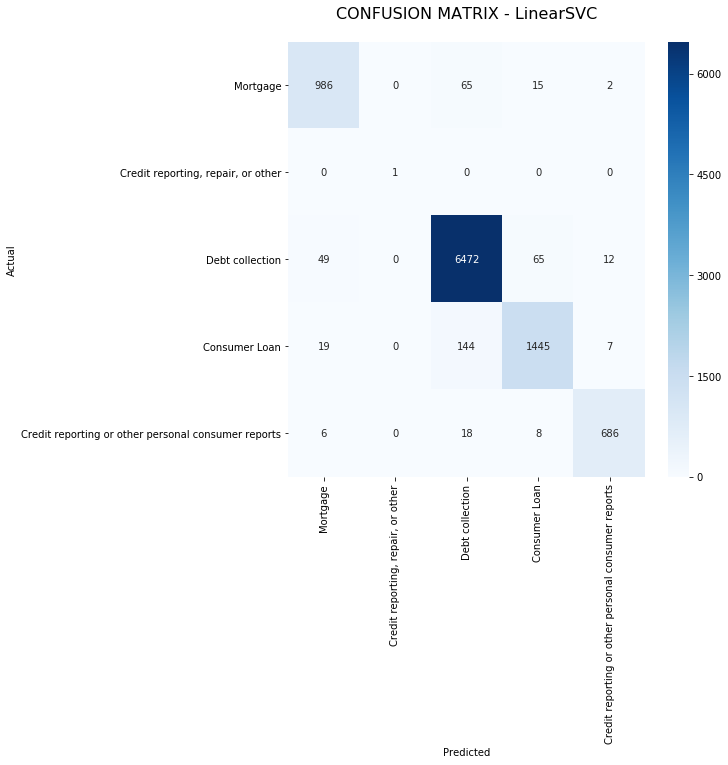

In [44]:
conf_mat = confusion_matrix(df3['Product'], Predictions)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Product.values, 
            yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

In [45]:
df3['Consumer_complaint'].iloc[0]

'Paying extremely high PMI for 11 years on my mortgage loan. I questioned the amount and have not been provided with any response as of XXXX/XXXX/XXXX. Also, Escrow amount seems excessive since XX/XX/XXXX and I am unable to reconcile what the increase is attributed to at this time.'

In [46]:
df3[df3['Consumer_complaint'] == df3['Consumer_complaint'].iloc[0]]

,Product,Consumer_complaint,category_id
1511706,Mortgage,Paying extremely high PMI for 11 years on my m...,0


In [47]:
complaint1 = """I WANT TO REQUEST A CREDIT LINE INCREASE OF XXXX I FELL I HAVE THE RIGHT CREDIT LINE DO TO MY INCOME AND THE LADY FROM CAPITAL ONE SAID IT IS BASED OFF INCOME 
AND ALSO DUE TO THE FACT THEY HAVE NOT MAILED MY CREDIT CARD TO ME YET AFTER I CALLED AND TOLD THEM TO. \n"""

In [48]:
print(model.predict(fitted_vectorizer.transform([complaint1])))

['Credit reporting, repair, or other']


It has predicted the first complaint correctly.

In [49]:
df3[df3['Consumer_complaint'] == df3['Consumer_complaint'].iloc[16]]

,Product,Consumer_complaint,category_id
3922346,Consumer Loan,This is very horrible and bad experience day I...,3


In [50]:
df3['Consumer_complaint'].iloc[16]

'This is very horrible and bad experience day I never have before. I was checking my online banking someone access on my account to do wire transferred. Normally I checked my online banking twice or three time in a day to see any transaction isnt normally. So thats why I catches them immediately. \n\nOn XX/XX/2022 around XXXX. The scammer is access on my bank account to wire transfer with {$50000.00}, around XXXX the scammer took second action wire transfer with {$30000.00}. The third transferred is around {$75000.00}. And I was going to my local Citibank immediately around XXXX. And let the local bank manager knows who name XXXX XXXX XXXX and let her knows someone access on my bank account and wire transfer without my any acknowledge. The Citibank assistant branch manager is working so hard and check my account, and tried to recall the funds. But the first and second funds has been sent to scammers bank which is XXXX XXXX XXXXXXXX and XXXX XXXX. And third one had been catch back. We d

In [51]:
complaint2 = """I have been actively filing loan modifications with B of A sinceXXXX. I am a XXXX Veteran and I did use my VA certificateto secure my home in XXXX. My home was finance thruCountry Wide before B of A bought my loan. B of A didservice my home for foreclosure while I was serving in theXXXX XXXX about XXXX XXXX and the loan was noteven 2 months behind. I came home in XXXX XXXX andrequested another loan modification but no response soI obtained an attorney. My attorney did respond to B ofA and requested all correspondence concerning my homebe sent to them and they were actively involved with myloan modification. In early XXXX I was notified by areal-estate agent that my home was listed for foreclosureand public auction. No XXXX service me or my attorney. Theforeclosure was listed in the local newspaper. This wasnews to me and my attorney since we both had no ideaand was actively involve with a loan modification at thetime. I have since been working with Attorney Generaloffice in Florida. I was given guidance from the AG tofile this complaint with CFPB along with their inquireabout my case. I have been told my request formodification has been denied for reasons such as \'\' I was not living in the home and it is a VA require-ment \'\' which is not true, " insufficient income \'\', mycurrent husband signed a form stating he wouldcontribute {$1500.00} additional income to my household to help cover the cost and the list goes on. \nI am currently enrolled in a XXXX programwith the XXXX VA and is receivingtreatment. My condition is described as " XXXX \'\' at this time but with support from my husbandand adult children I am trying to do what isnecessary to keep my home. I am filing thiscomplaint because I too believe I am a victimof " dual tracking \'\' with B of A. They are notowning up to their constant mistakes. I don\'tunderstand why they will not work with me tohelp me keep my home vice foreclosing. I amnot trying to run from my responsibility of payingfor my home. I just need help with lowering the payment so I can afford it. Is that too much to ask for? \nB of A pulled back the foreclosure because they justrealized we were working on a loan modification with mebut recently filed a petition in court another foreclosure. \nI have no other option but to file bankruptcy to keepmy home. This not fair to me the consumer because allI wanted was a lower payment. \n"""

In [52]:
print(model.predict(fitted_vectorizer.transform([complaint2])))

['Mortgage']


It has predicted the second complaint correctly as well. Thus, the model is doing a good job in predicting the product category using the Consumer Complaint narratives.

# Part 3 : CLASSIFICATION MODELS AND FEATURE ENGINEERING

In [53]:
df = pd.read_csv('/kaggle/input/19mia1073-complaints/complaints.csv')

In [54]:
df.head(5).T

,0,1,2,3,4
Date received,2023-08-25,2023-08-25,2023-08-25,2023-08-25,2023-08-25
Product,Credit reporting or other personal consumer re...,Credit reporting or other personal consumer re...,Credit reporting or other personal consumer re...,Credit reporting or other personal consumer re...,Credit reporting or other personal consumer re...
Sub-product,Credit reporting,Credit reporting,Credit reporting,Credit reporting,Credit reporting
Issue,Problem with a company's investigation into an...,Incorrect information on your report,Improper use of your report,Problem with a company's investigation into an...,Problem with a company's investigation into an...
Sub-issue,Their investigation did not fix an error on yo...,Information belongs to someone else,Credit inquiries on your report that you don't...,Their investigation did not fix an error on yo...,Their investigation did not fix an error on yo...
Consumer complaint narrative,NaN,NaN,NaN,NaN,NaN
Company public response,NaN,NaN,NaN,NaN,NaN
Company,"EQUIFAX, INC.","EQUIFAX, INC.","EQUIFAX, INC.","EQUIFAX, INC.","EQUIFAX, INC."
State,PA,GA,FL,PA,NV
ZIP code,15146,30152,32137,15146,89135


In [55]:
df.shape

(4078867, 18)

In [56]:
df1 = df.copy()

Making a copy of the dataset to perform the operations and prepare a good dataset for training and testing.

In [57]:
df1.drop(['Date received','Date sent to company','Sub-product','Issue', 
          'Sub-issue','Consumer complaint narrative','ZIP code','Complaint ID'],axis=1,inplace=True)

Dropping Sub-product,Issue, Sub-issue as all of them are related to the Product Column. Dropping the Date columns as they don't have much contribution and the same goes for ZIP code and Complaint ID.

In [58]:
df1.shape

(4078867, 10)

In [59]:
df1.isnull().sum()

Product                               0
Company public response         2190771
Company                               0
State                             43208
Tags                            3652908
Consumer consent provided?       900882
Submitted via                         0
Company response to consumer          5
Timely response?                      0
Consumer disputed?              3310509
dtype: int64

We can see that there a lot of null values in the Dataset.

In [60]:
df1['Company public response'].value_counts()

Company has responded to the consumer and the CFPB and chooses not to provide a public response                            1659782
Company believes it acted appropriately as authorized by contract or law                                                    127380
Company chooses not to provide a public response                                                                             52473
Company believes the complaint is the result of a misunderstanding                                                           12390
Company disputes the facts presented in the complaint                                                                        10109
Company believes complaint caused principally by actions of third party outside the control or direction of the company       7531
Company believes complaint is the result of an isolated error                                                                 6077
Company believes complaint represents an opportunity for improvement to better serv

The most common company response is Company chooses not to provide a public response which we can use to fill the remaining NA values.

In [61]:
df1['Consumer consent provided?'].value_counts()

Consent not provided    1541226
Consent provided        1478590
Other                    150894
Consent withdrawn          7275
Name: Consumer consent provided?, dtype: int64

In Consumer consent provided? column Other seems to be a neutral column that can be used to fill in the NA values.

In [62]:
df1['Tags'].value_counts()

Servicemember                    246499
Older American                   144447
Older American, Servicemember     35013
Name: Tags, dtype: int64

The information available is very less and there is no neutral value that we can use to fill the NA values. 

In [63]:
df1.drop(['Tags'],axis=1,inplace=True)

Dropping the Tags column.

In [64]:
df1.shape

(4078867, 9)

In [65]:
df1['Company public response'].notnull().sum()

1888096

In [66]:
df1['Consumer consent provided?'].fillna('Other',inplace=True)

Filling the NA values in **Consumer consent provided?** with **'Other'**.

In [67]:
df1['Consumer consent provided?'].isnull().sum()

0

In [68]:
df1.isnull().sum()

Product                               0
Company public response         2190771
Company                               0
State                             43208
Consumer consent provided?            0
Submitted via                         0
Company response to consumer          5
Timely response?                      0
Consumer disputed?              3310509
dtype: int64

In [69]:
df1['Company public response'].fillna('Company chooses not to provide a public response',inplace=True)

Filling the NA values in Company public response column with **'Company chooses not to provide a public response'**.

In [70]:
df1.isnull().sum()

Product                               0
Company public response               0
Company                               0
State                             43208
Consumer consent provided?            0
Submitted via                         0
Company response to consumer          5
Timely response?                      0
Consumer disputed?              3310509
dtype: int64

There are NA values in the state columns and it is something we can't just fill in randomly. Hence, dropping those NA values.

In [71]:
df1.dropna(inplace=True)

In [72]:
df1.shape

(762708, 9)

There are **355907** after cleaning which a really good number to work on.

In [73]:
df1.head(5).T

,30285,36370,38916,44225,44366
Product,Credit card,Credit reporting,Credit card,Mortgage,Mortgage
Company public response,Company chooses not to provide a public response,Company chooses not to provide a public response,Company chooses not to provide a public response,Company chooses not to provide a public response,Company chooses not to provide a public response
Company,CAPITAL ONE FINANCIAL CORPORATION,"EQUIFAX, INC.",CAPITAL ONE FINANCIAL CORPORATION,PNC Bank N.A.,"SUNTRUST BANKS, INC."
State,NJ,OK,FL,PA,FL
Consumer consent provided?,Other,Consent not provided,Other,Consent not provided,Other
Submitted via,Web,Web,Postal mail,Web,Referral
Company response to consumer,Closed with explanation,Closed with explanation,Closed with explanation,Closed with explanation,Closed with explanation
Timely response?,Yes,Yes,Yes,Yes,Yes
Consumer disputed?,No,No,No,No,Yes


In [74]:
from sklearn.preprocessing import LabelEncoder

In [75]:
df1 = df1.apply(LabelEncoder().fit_transform)

Converting all the object columns using ****Label Encoder()****.

In [76]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 762708 entries, 30285 to 4078863
Data columns (total 9 columns):
Product                         762708 non-null int64
Company public response         762708 non-null int64
Company                         762708 non-null int64
State                           762708 non-null int64
Consumer consent provided?      762708 non-null int64
Submitted via                   762708 non-null int64
Company response to consumer    762708 non-null int64
Timely response?                762708 non-null int64
Consumer disputed?              762708 non-null int64
dtypes: int64(9)
memory usage: 58.2 MB


Let's have a look at the dataset after conversion.

In [77]:
df1.head()

,Product,Company public response,Company,State,Consumer consent provided?,Submitted via,Company response to consumer,Timely response?,Consumer disputed?
30285,3,7,683,39,3,5,1,1,0
36370,4,7,1358,44,0,5,1,1,0
38916,3,7,683,13,3,3,1,1,0
44225,7,7,2988,46,0,5,1,1,0
44366,7,7,3532,13,3,4,1,1,1


Because the computation is time consuming (in terms of CPU), the data was sampled.

In [78]:
df2 = df1.sample(10000, random_state=1).copy()

In [79]:
df2['Consumer disputed?'].value_counts()

0    8016
1    1984
Name: Consumer disputed?, dtype: int64

We can conclude that the data isn't balanced.

# Model Building :

* Let's define our **X** and **Y** and start working on the training the model.

In [80]:
X = df2.drop(['Consumer disputed?'],axis=1)
y = df2['Consumer disputed?']

In [81]:
from sklearn.model_selection import train_test_split

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

Since it is an **imbalanced dataset**, we will set the <b>class_weight</b> parameter to 'balanced'

In [83]:
log_reg = LogisticRegression(random_state=101,class_weight='balanced')

In [84]:
log_reg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=101,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [85]:
predictions = log_reg.predict(X_test)

In [86]:
from sklearn.metrics import classification_report

0.4784
********************************************
Confusion matrix


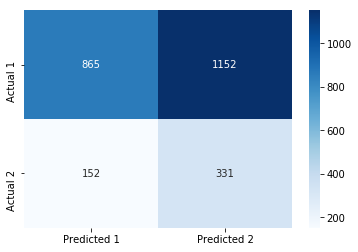

**********************************************
              precision    recall  f1-score   support

           0       0.85      0.43      0.57      2017
           1       0.22      0.69      0.34       483

   micro avg       0.48      0.48      0.48      2500
   macro avg       0.54      0.56      0.45      2500
weighted avg       0.73      0.48      0.53      2500



In [87]:
import seaborn as sns
print(metrics.accuracy_score(y_test,predictions))
print('********************************************')
print('Confusion matrix')
lr_cfm=metrics.confusion_matrix(y_test, predictions)


lbl1=["Predicted 1", "Predicted 2"]
lbl2=["Actual 1", "Actual 2"]

sns.heatmap(lr_cfm, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2)
plt.show()

print('**********************************************')
print(metrics.classification_report(y_test,predictions))

The overall accuracy is less and the precision and f1-score is really low for 1. Let's try out other methods.

In [88]:
from sklearn.metrics import roc_curve, auc

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)
print (roc_auc)

0.5570774708969617


Text(0.5, 0, 'False Positive Rate')

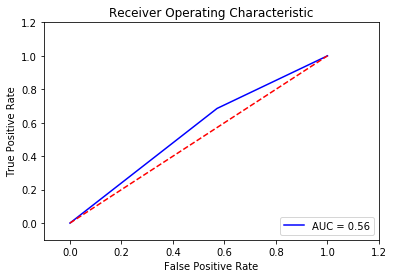

In [89]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

The accuracy can be low due to the fact that there are a lot of <b>categorical variables</b> in the dataset. As there is a lot of <b>non-linearity</b>, let us use <b>tree</b> algorithms.

# Random Forest :

We will try the <b>Bagging</b> technique <b>Random Forest</b> on the dataset. Since we do not know the optimal hyperparameters for the forest, let us use GridSearch cross-validation to identify them.

# Grid Search :

Here are the parameters for <a href='https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV'>GridSearchCV</a>:
- __estimator__: `model`
- __param_grid__: `dist or list of dictionaries` Parameters to the estimator/model
- __scoring__: `string,callable, list/tuple, dict or None, default: None` Evaluating metrics
- __cv__: `int or callable` Cross validation

In [90]:
from sklearn.ensemble import RandomForestClassifier
random_grid = {'n_estimators': range(5,20,3),
              'max_features' : ['auto', 'sqrt'],
              'max_depth' : [5,10,20,30],
              'min_samples_split':[2,5,10],
              'criterion':['entropy'],
              'min_samples_leaf':[1,2,4]}

rf=RandomForestClassifier(oob_score=True,class_weight='balanced')
rf_gs = GridSearchCV(rf, random_grid, cv = 5, n_jobs=-1, verbose=2)

rf_gs.fit(X_train, y_train)
y_pred = rf_gs.predict(X_test)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 221 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 627 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 1193 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 1793 out of 1800 | elapsed:  1.2min remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:  1.2min finished


0.7412
*******************************************
Confusion matrix


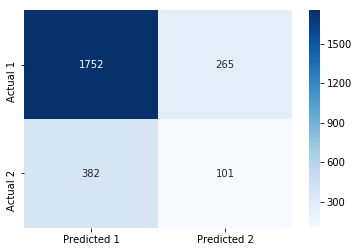

********************************************
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      2017
           1       0.28      0.21      0.24       483

   micro avg       0.74      0.74      0.74      2500
   macro avg       0.55      0.54      0.54      2500
weighted avg       0.72      0.74      0.73      2500



In [91]:
print(metrics.accuracy_score(y_test,y_pred))
print('*******************************************')
print('Confusion matrix')
rf_cfm=metrics.confusion_matrix(y_test, y_pred)

lbl1=["Predicted 1", "Predicted 2"]
lbl2=["Actual 1", "Actual 2"]

sns.heatmap(rf_cfm, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2)
plt.show()

print('********************************************')
print(metrics.classification_report(y_test,y_pred))

The accuracy has surely increased ! But hold on...we need to remember that it is an imbalanced dataset. Let us calculate the null accuracy.

In [92]:
# Actual Values of y_test
print (y_test.value_counts())
print ("Null Accuracy:",y_test.value_counts().head(1) / len(y_test))

0    2017
1     483
Name: Consumer disputed?, dtype: int64
Null Accuracy: 0    0.8068
Name: Consumer disputed?, dtype: float64


Null accuracy itself is **0.80**. So our accuracy of **0.74** is less than that. Also, as discussed earlier, **f1-score** is more important in these scenarios. But even that is pretty low. 

For imbalanced datasets, ROC_AUC is considered to be a more relevant metric than f1-score and accuracy as it is independent of threshold value.

In [93]:
predict_probabilities = rf_gs.predict_proba(X_test)
final_metric = roc_auc_score(y_test, predict_probabilities[:,1])
print (final_metric)

0.5523736644320378


Now, this is a metric that makes sense. We should get the **ROC_AUC** score as close to 1 as possible. Let us now see how Boosting algorithms fare.

# XGBoost : 

In [94]:
from xgboost.sklearn import XGBClassifier

In [95]:
xgb_model = XGBClassifier(num_class = 2,
                           objective="multi:softprob",
                           eval_metric="mlogloss",
                           seed=42) 

In [96]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='mlogloss', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, num_class=2, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=True, subsample=1)

In [97]:
xgboost_pred=xgb_model.predict(X_test)

0.8068
************
Confusion matrix


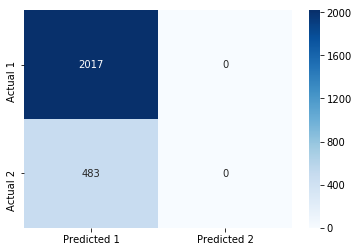

************
 Classification report
              precision    recall  f1-score   support

           0       0.81      1.00      0.89      2017
           1       0.00      0.00      0.00       483

   micro avg       0.81      0.81      0.81      2500
   macro avg       0.40      0.50      0.45      2500
weighted avg       0.65      0.81      0.72      2500



In [98]:
print(metrics.accuracy_score(y_test,xgboost_pred))
print('************')
print('Confusion matrix')
xgboost_cm=metrics.confusion_matrix(y_test, xgboost_pred)


lbl1=["Predicted 1", "Predicted 2"]
lbl2=["Actual 1", "Actual 2"]

sns.heatmap(xgboost_cm, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2)

plt.show()

print('************\n Classification report')
print(metrics.classification_report(y_test,xgboost_pred))

We are at a pretty good accuracy of 0.80 which is slightly higher than our Null Accuracy of 0.79 though the recall and f1-score of 1 is 0.

In [99]:
predict_probabilities = xgb_model.predict_proba(X_test)
from sklearn.metrics import roc_auc_score
final_metric = roc_auc_score(y_test, predict_probabilities[:,1])
print (final_metric)

0.6174257937962104


Xgboost gives us a higher ROC_AUC score compared to Random Forest. 

# XgBoost with Grid Search :

In [100]:
xgb_gs_clf = XGBClassifier(num_class = 2,
                           objective="multi:softprob",
                           eval_metric="mlogloss",
                           seed=42)                         
                        
param_grid = {"max_depth": [10,15,20],
              "n_estimators": range(5,20,5) , 
              "gamma": [0.03,0.05], 
              "learning_rate": [0.01,0.05]}
#              "min_child_weight": [5,10], 
#              "colsample_bytree": [0.4,0.8], 
#              "subsample": [0.50,0.85]} 

grid_search = GridSearchCV(xgb_gs_clf, 
                           param_grid=param_grid,
                           cv = 5,
                           n_jobs=-1,
                           scoring='neg_log_loss',
                           verbose=2)
grid_search.fit(X_train,y_train)
grid_search.best_params_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   22.8s finished


{'gamma': 0.05, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 15}

In [101]:
xgboost_y_pred=grid_search.predict(X_test)    

0.794
*************************************************
Confusion matrix


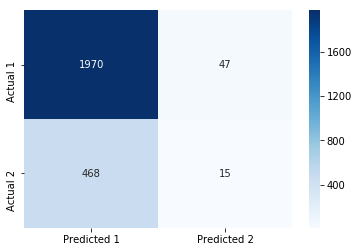

***************************************************
 Classification report
              precision    recall  f1-score   support

           0       0.81      0.98      0.88      2017
           1       0.24      0.03      0.06       483

   micro avg       0.79      0.79      0.79      2500
   macro avg       0.52      0.50      0.47      2500
weighted avg       0.70      0.79      0.72      2500



In [102]:
print(metrics.accuracy_score(y_test,xgboost_y_pred))
print('*************************************************')
print('Confusion matrix')
xgboost_cfm=metrics.confusion_matrix(y_test, xgboost_y_pred)


lbl1=["Predicted 1", "Predicted 2"]
lbl2=["Actual 1", "Actual 2"]

sns.heatmap(xgboost_cfm, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2)

plt.show()

print('***************************************************\n Classification report')
print(metrics.classification_report(y_test,xgboost_y_pred))

In [103]:
predict_probabilities = grid_search.predict_proba(X_test)
final_metric = roc_auc_score(y_test, predict_probabilities[:,1])
print (final_metric)

0.5907611390140328


There is no improvement over the earlier Xgboost model. Let's try out with <b>more hyperparameter combinations</b> and see if there is a jump in the roc_auc value.

# LightGBM :

In [104]:
import lightgbm as lgb

d_train= lgb.Dataset(X_train, label = y_train) 

In [105]:
params = {}
params['learning_rate'] = 0.001                                             # Learning rate
params['boosting_type'] = 'gbdt'                                           # gbdt = gradient boosted decision tree
params['objective'] = 'multiclass'                                         # Multi class classification
params['metric'] = 'multi_logloss'
params['num_classes'] = 5 
params['eval_metric']='auc', 'binary_logloss'
#params['sub_feature'] = 0.5
#params['min_data'] = 50
#params['max_depth'] = 10


clf = lgb.train(params, d_train)     

In [106]:
#Prediction
y_pred=clf.predict(X_test)

In [107]:
clf.params

{'learning_rate': 0.001,
 'boosting_type': 'gbdt',
 'objective': 'multiclass',
 'metric': 'multi_logloss',
 'num_classes': 5,
 'eval_metric': ('auc', 'binary_logloss')}

In [108]:
predictions = []
predictions_proba = []
for x in y_pred:
    predictions.append(np.argmax(x))
    predictions_proba.append(max(x))

In [109]:
lgb_y_pred = np.array(predictions)

0.8068
*************************************************
Confusion matrix


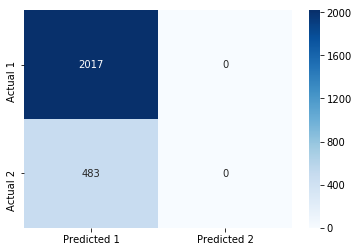

***************************************************
 Classification report
              precision    recall  f1-score   support

           0       0.81      1.00      0.89      2017
           1       0.00      0.00      0.00       483

   micro avg       0.81      0.81      0.81      2500
   macro avg       0.40      0.50      0.45      2500
weighted avg       0.65      0.81      0.72      2500



In [110]:
print(metrics.accuracy_score(y_test,lgb_y_pred))
print('*************************************************')
print('Confusion matrix')
lgb_cfm=metrics.confusion_matrix(y_test, lgb_y_pred)


lbl1=["Predicted 1", "Predicted 2"]
lbl2=["Actual 1", "Actual 2"]

sns.heatmap(lgb_cfm, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2)

plt.show()

print('***************************************************\n Classification report')
print(metrics.classification_report(y_test,lgb_y_pred))

In [111]:
final_metric = roc_auc_score(y_test, predictions_proba)
print (final_metric)

0.3903938674476063


<b>LightGBM</b> performance is not upto the mark.It is unable to correctly classify even a single datapoint that belonged to class 1. We can conclude that <b>Consumer Complaints</b> can use the <b>XGboost</b> model to identify if the Consumer Disputed or not.